# Modelo de ML para bajar el imparto de CO2
El siguiente modelo nos da una clacificación de los vehiculos que mas CO2 producen hasta los que producen menos

In [68]:
# Bibliotecas que vamos a importar 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [50]:
# Traemos los datos y los dejamos en un dataframe
df_convencional = pd.read_parquet('../Data/df_vfed.parquet')

In [51]:
# Revición de datos a nivel global
df_convencional.head(2)

,Year,Manufacturer,Model,Miles per gallon (mpg),CO2 (p/mile),FuelCost,FuelCostA,Fuel,Category,Alternative Fuel
0,2017,BMW,M6 Coupe,15.0,519.0,3850.0,0.0,Premium Gasoline,Subcompact Cars,No
1,2017,BMW,X3 sDrive28i,21.0,374.0,2700.0,0.0,Premium Gasoline,Small Sport Utility Vehicle 2WD,No


In [52]:

# Usamos One-Hot Encoding para comvertir en columna categorica
df_convencional = pd.get_dummies(df_convencional, columns=['Fuel'])

In [53]:
df_convencional.head(2)

,Year,Manufacturer,Model,Miles per gallon (mpg),CO2 (p/mile),FuelCost,FuelCostA,Category,Alternative Fuel,Fuel_Diesel,Fuel_Electricity,Fuel_Midgrade Gasoline,Fuel_Natural Gas,Fuel_Premium Gasoline,Fuel_Regular Gasoline
0,2017,BMW,M6 Coupe,15.0,519.0,3850.0,0.0,Subcompact Cars,No,False,False,False,False,True,False
1,2017,BMW,X3 sDrive28i,21.0,374.0,2700.0,0.0,Small Sport Utility Vehicle 2WD,No,False,False,False,False,True,False


In [54]:
# Dejamos las columnas que vamos a utilizar
Convencional_Colu = df_convencional[['Year', 'Miles per gallon (mpg)', 'CO2 (p/mile)', 'FuelCost', 'Fuel_Diesel', 'Fuel_Electricity', 'Fuel_Midgrade Gasoline', 'Fuel_Natural Gas', 'Fuel_Premium Gasoline', 'Fuel_Regular Gasoline']]

In [55]:
# Calculo de matriz de correlkación 
correlacion_matrix = Convencional_Colu.corr()

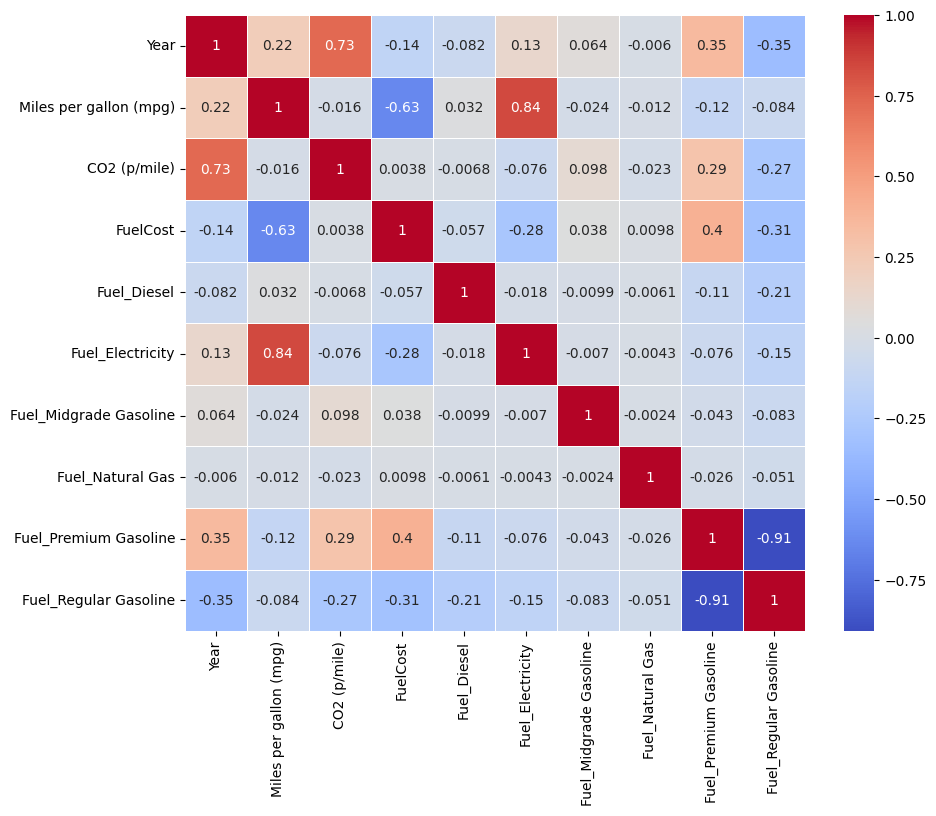

In [56]:
# Mapa de calor donde podemos ver que columnas tienen mayor correlación con el CO2
plt.figure(figsize=(10,8))
sns.heatmap(correlacion_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

In [57]:
# Columnas que vamos a escoger
Columnas_relebantes = Convencional_Colu[['CO2 (p/mile)', 'Year','Fuel_Premium Gasoline', 'Fuel_Regular Gasoline' ]]

In [58]:
# Trasformación de las columnas de tipo categorico a int
Columnas_relebantes['Fuel_Premium Gasoline'] = Columnas_relebantes['Fuel_Premium Gasoline'].astype(int)
Columnas_relebantes['Fuel_Regular Gasoline'] = Columnas_relebantes['Fuel_Regular Gasoline'].astype(int)

In [60]:
# Estandarizar las columnas 
scaler = StandardScaler()
Columnas_relebantes_sacled = scaler.fit_transform(Columnas_relebantes)

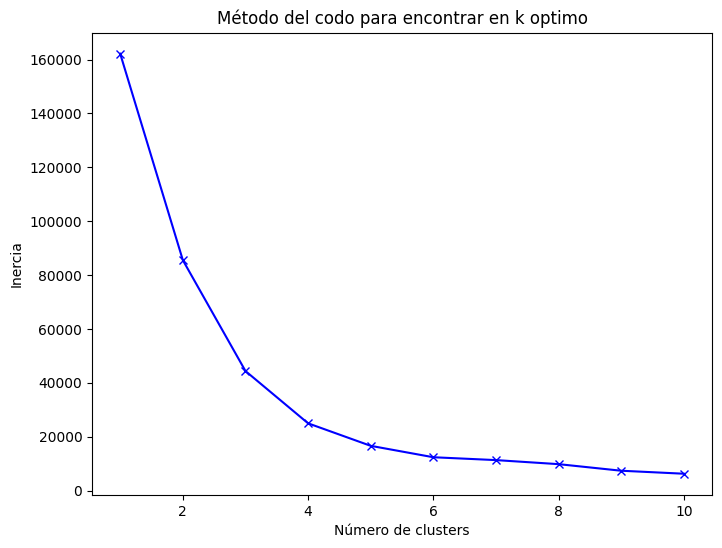

In [63]:
# Provamos diferentes valores de K para encontrar el óptimo 
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(Columnas_relebantes_sacled)
    inertia.append(kmeans.inertia_)

# Graficamos el método codo
plt.figure(figsize=(8,6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del codo para encontrar en k optimo')
plt.show()


En el anterior grafico podemos decir que paraq este modelo valos a utilizar 4 cluster 

In [64]:
# Ahora teniendo el número de clusters vamos aplicarlo a nuestro modelo 
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(Columnas_relebantes_sacled)

# Agregamos las etiquetas al Dataframe original
df_convencional['cluster'] = kmeans.labels_

In [67]:
# Calcular el Silhouette Score
silhouette_avg = silhouette_score(Columnas_relebantes_sacled, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')
# Podemos concluir se pueden mejorar 

Silhouette Score: 0.6598869493569658


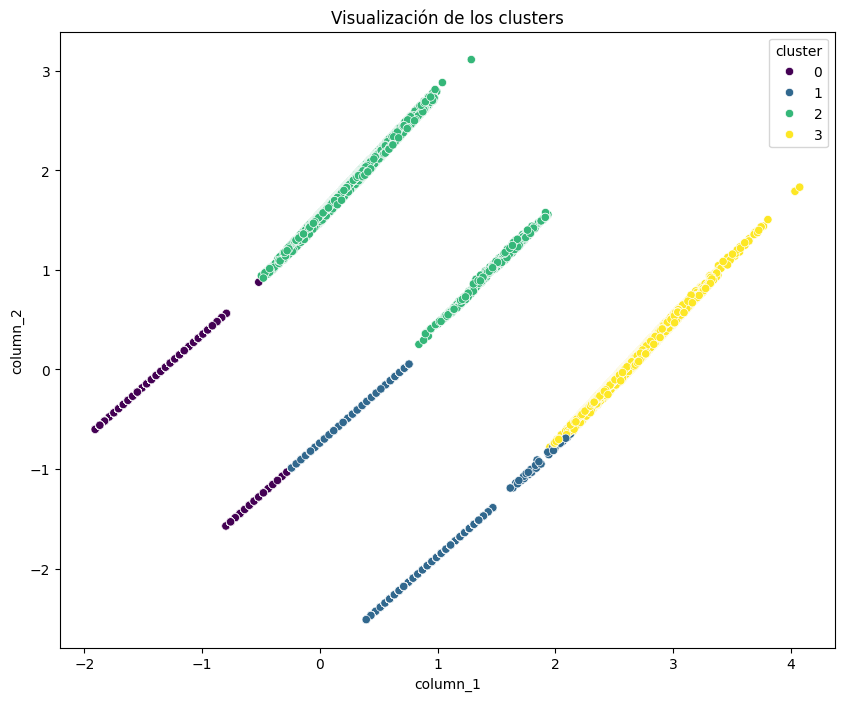

In [69]:
#Aplicamos PCA para reducir dimenciones 
pca = PCA(n_components=2)
pca_result =pca.fit_transform(Columnas_relebantes_sacled)

# Creamos un nuevo dataframe
df_pca = pd.DataFrame(pca_result, columns=['column_1', 'column_2'])
df_pca['cluster'] = kmeans.labels_

# Visualización de los clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='column_1', y='column_2', hue='cluster', palette='viridis', data=df_pca)
plt.title('Visualización de los clusters')
plt.show()